In [60]:
import pandas as pd
import numpy as np

Parameters for the Analysis

In [61]:
analysis_year = 2003 # Year to be analyzed
noaa_filenames = ['2003.txt', '2004.txt'] # analysis year , next year
year_prefix = '200' # need to adjust based in the year for 2003 it is 200, for 2010 it is 20, for 1996 it is 19.

Read in SOHO-LASCO CME Catalog (All Available Years)

In [ ]:
# Import Catalog of Coronal Mass Ejection Data
# Data is in fixed width file format
data_file = 'SOHO-LASCO_CME_Catelog_univ_all.txt'
colspecs = [(0,10), (12,20), (24,27), (32,34), (37,41), (45,49), (52,56), (59,63), (66,72), (72,73), (76,83), (83,84), (87,94), (94,95), (98,101), (104, 147)]
names = ['Date', 'Time', 'CentralPA', 'Width', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'AFlag', 'Mass', 'MFlag', 'KineticEnergy', 'KEFlag', 'MPA',
'Remarks']
cme = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=4)
# Create the index as a datetime
cme.index = pd.to_datetime(cme.Date)

#cme.convert_objects(convert_numeric=True).dtypes # some columns can be converted 
cols_to_convert_to_float64 = ['CentralPA', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'Mass', 'KineticEnergy']
for col in cols_to_convert_to_float64:
    cme[col] = pd.to_numeric(cme[col], errors='coerce')


Create a series to analyze Linear Speed.  Create 1 entry per date with max of LinearSpeed

In [89]:
#cme_1year = cme[(cme.index.year==analysis_year)]
linear_max = cme.groupby([cme.index])['LinearSpeed'].max()
linear_max = linear_max[(linear_max.index.year==analysis_year)]
#result2 = pd.concat([result, summarized], axis=1, join_axes=[result.index])
#new_columns = result2.columns.values; new_columns[len(new_columns)-1] = 'LinearSpeed_max'
#result2.columns = new_columns
#result2

Date
2003-01-01     432.0
2003-01-02     655.0
2003-01-03     682.0
2003-01-04     411.0
2003-01-05    1183.0
2003-01-06     502.0
2003-01-07     365.0
2003-01-08     653.0
2003-01-09     831.0
2003-01-10    1770.0
2003-01-11     536.0
2003-01-12     441.0
2003-01-13     584.0
2003-01-14     882.0
2003-01-15     488.0
2003-01-16     430.0
2003-01-17     385.0
2003-01-18     550.0
2003-01-19     570.0
2003-01-20     733.0
2003-01-21    1011.0
2003-01-22    1855.0
2003-01-23    1236.0
2003-01-24     513.0
2003-01-25     481.0
2003-01-26    1652.0
2003-01-27    1053.0
2003-01-28      88.0
2003-01-29     582.0
2003-01-30     662.0
               ...  
2003-11-25     791.0
2003-11-27     618.0
2003-11-28     422.0
2003-11-30     495.0
2003-12-01     552.0
2003-12-02    1393.0
2003-12-03     532.0
2003-12-04     529.0
2003-12-05     403.0
2003-12-06     676.0
2003-12-07     392.0
2003-12-08     503.0
2003-12-09     517.0
2003-12-10     586.0
2003-12-11     447.0
2003-12-12     513.0
2003-12-

Read in NOAA - 2 years worth == primary year + following year

In [63]:
data_file = noaa_filenames[0]
colspecs = [(0,2), (2,4), (4,6), (6,10), (10,12), (12,14), (14,16), (16,18), (18,20), (20,22), (22,24), (24,26), (26,28), (28,30), 
            (58,60), (61, 62), (62,65)]
names = ['Year', 'Month', 'Day', 'Bartels', 'BDay', 'Kp0', 'Kp3', 'Kp6', 'Kp9', 'Kp12', 'Kp15', 'Kp18', 'Kp21', 'KpSum', 'Cp',
'C9', 'ISN']
noaa = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)

# We need the first 14 days of the next year's data to support time shifting described below.
data_file = noaa_filenames[1]
noaa2 = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)
noaa = pd.concat([noaa, noaa2])

In [64]:
# Create datetime index using the individual columns for Year, Month and Day
str_date =  year_prefix + noaa.Year.astype(str) + '/' + noaa.Month.astype(str) + '/' + noaa.Day.astype(str)
noaa['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa.index = noaa.Date

In [65]:
# Time shifting the C9 data in 1 day increments for 14 days so that we can compare solar activity to future space weather on Earth
C9 = noaa.C9
for n in range(-1,-15,-1):
    shifted_forward =  C9.shift(n)  
    noaa = noaa.join(shifted_forward, rsuffix=str(n))

noaa = noaa[(noaa.index.year == analysis_year)]    
noaa.tail()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,...,C9-5,C9-6,C9-7,C9-8,C9-9,C9-10,C9-11,C9-12,C9-13,C9-14
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-27,3,12,27,2326,5,17,30,10,27,17,...,6.0,4.0,5.0,5.0,6.0,5.0,6.0,1.0,5.0,6.0
2003-12-28,3,12,28,2326,6,37,37,20,23,27,...,4.0,5.0,5.0,6.0,5.0,6.0,1.0,5.0,6.0,5.0
2003-12-29,3,12,29,2326,7,13,0,10,17,17,...,5.0,5.0,6.0,5.0,6.0,1.0,5.0,6.0,5.0,2.0
2003-12-30,3,12,30,2326,8,10,10,13,3,13,...,5.0,6.0,5.0,6.0,1.0,5.0,6.0,5.0,2.0,5.0
2003-12-31,3,12,31,2326,9,30,20,13,23,30,...,6.0,5.0,6.0,1.0,5.0,6.0,5.0,2.0,5.0,3.0


Join the two dataframes together matching the cme data to the noaa data

In [94]:
result = pd.concat([ noaa, linear_max], axis=1, join_axes=[linear_max.index])
new_columns = result.columns.values; new_columns[len(new_columns)-1] = 'LinearSpeed_max'
result.columns = new_columns

#cme_1year = cme[(cme.index.year==analysis_year)]
#result = pd.concat([cme_1year, noaa], axis=1, join_axes=[cme_1year.index])
result.head()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,...,C9-6,C9-7,C9-8,C9-9,C9-10,C9-11,C9-12,C9-13,C9-14,LinearSpeed_max
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,3,1,1,2312,23,10,23,27,13,20,...,1.0,0.0,0.0,3.0,2.0,2.0,2.0,2.0,1.0,432.0
2003-01-02,3,1,2,2312,24,23,10,10,17,17,...,0.0,0.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,655.0
2003-01-03,3,1,3,2312,25,27,7,20,17,27,...,0.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,682.0
2003-01-04,3,1,4,2312,26,47,43,23,20,23,...,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,411.0
2003-01-05,3,1,5,2312,27,17,17,17,13,20,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,5.0,1183.0


In [92]:
#summarized = result[(result['C9-2']>=9.0)]
#summarized = result.groupby([result.index])['LinearSpeed'].max()
#result2 = pd.concat([result, summarized], axis=1, join_axes=[result.index])
#new_columns = result2.columns.values; new_columns[len(new_columns)-1] = 'LinearSpeed_max'
#result2.columns = new_columns
#result2

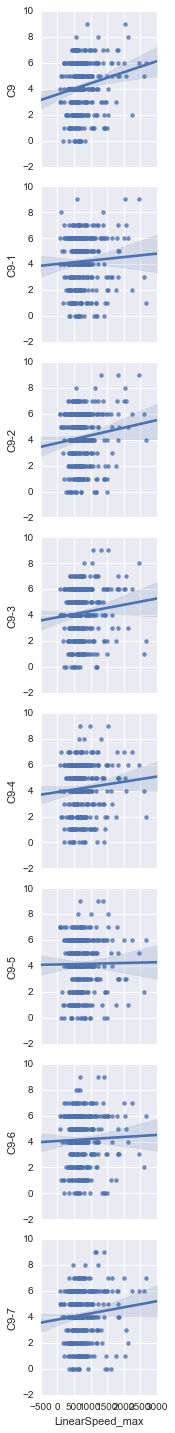

In [98]:
%matplotlib inline
import seaborn as sns
feature_cols = ['C9', 'C9-1', 'C9-2', 'C9-3', 'C9-4', 'C9-5', 'C9-6', 'C9-7']
sns.pairplot(result, y_vars=feature_cols, x_vars='LinearSpeed_max', kind='reg')